# Imports

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Device Configuration

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Image Transforms

In [11]:
IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),          # [0,1]
])


# LOAD & EXPLORE DATASET
## Custom Dataset (No Labels) 

In [12]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


# LOAD DATASET

In [7]:
# confirm the directory
import os 
print(os.listdir("/kaggle/input/product-images-dataset/small"))

['d8', '0d', '47', '17', '81', 'c5', '19', 'e2', '8f', 'a2', '22', 'cf', 'b8', '35', '92', 'b2', '50', 'c7', '23', '5b', '87', '07', 'd5', '10', 'd0', 'cd', '61', '1b', 'bf', '2e', '36', '05', '20', '06', '0f', '45', '60', '27', '6d', '64', '41', 'c8', '9e', 'da', 'ff', '89', '39', '0c', '4d', '02', '32', '98', '25', '42', 'b1', 'e5', 'b4', '52', 'f0', 'ac', 'd9', 'e0', '75', '0a', '8b', '2c', '38', '7d', '12', 'dc', 'ef', '94', '55', 'a0', 'e1', 'e7', '04', 'be', 'f1', '7e', 'ea', '49', 'fc', 'e3', 'e4', 'b9', '6e', '31', 'f9', '62', 'b6', '53', '1a', 'd2', '70', '34', '18', '4b', 'db', '79', '85', 'c2', '88', '65', '1e', '67', 'ec', 'ab', 'a3', 'a7', '78', '0e', 'd6', '28', 'f4', '66', 'cb', 'a5', 'a8', 'bc', 'e6', '56', '72', '6c', '16', '7b', 'bb', 'af', '9f', 'bd', 'ba', '13', '99', '1d', '4e', '3e', '7f', '26', 'b5', 'fb', 'd4', '4c', '74', 'b0', 'c6', '00', 'c4', '08', '15', 'ae', '90', '69', 'f8', '77', 'd1', 'f5', '3f', '9b', 'cc', '86', '95', 'f3', '43', 'ce', 'eb', '91', '3c

In [13]:

IMAGE_DIR = "/kaggle/input/product-images-dataset/small/01"

dataset = ImageDataset(IMAGE_DIR, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


# VISUALIZE RANDOM IMAGES (SANITY CHECK)

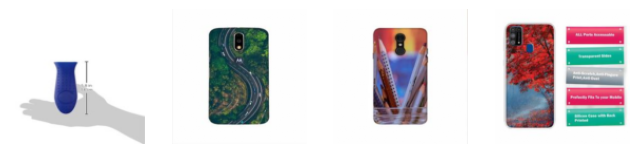

In [14]:
images = next(iter(dataloader))

plt.figure(figsize=(8,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images[i].permute(1,2,0))
    plt.axis("off")
plt.show()


# DEFINE CNN AUTOENCODER (FROM SCRATCH)
## Encoder (Feature Extractor)

In [15]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 128)   # embedding vector
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


## Decoder (For Reconstruction)

In [16]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(128, 128 * 16 * 16),
            nn.ReLU()
        )

        self.deconv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 16, 16)
        x = self.deconv(x)
        return x


## Autoencoder Wrapper

In [17]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon


# INITIALIZE MODEL

In [18]:
model = Autoencoder().to(device)


# LOSS & OPTIMIZER

In [20]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# TRAIN THE AUTOENCODER

In [21]:
EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0
    for images in dataloader:
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss:.4f}")


Epoch [1/30], Loss: 6.2912
Epoch [2/30], Loss: 3.8048
Epoch [3/30], Loss: 2.9586
Epoch [4/30], Loss: 2.6808
Epoch [5/30], Loss: 2.4668
Epoch [6/30], Loss: 2.2636
Epoch [7/30], Loss: 2.1339
Epoch [8/30], Loss: 1.9883
Epoch [9/30], Loss: 1.8587
Epoch [10/30], Loss: 1.7410
Epoch [11/30], Loss: 1.6540
Epoch [12/30], Loss: 1.5960
Epoch [13/30], Loss: 1.5167
Epoch [14/30], Loss: 1.4408
Epoch [15/30], Loss: 1.3278
Epoch [16/30], Loss: 1.2814
Epoch [17/30], Loss: 1.2464
Epoch [18/30], Loss: 1.2265
Epoch [19/30], Loss: 1.1601
Epoch [20/30], Loss: 1.0944
Epoch [21/30], Loss: 1.0415
Epoch [22/30], Loss: 1.0285
Epoch [23/30], Loss: 1.0236
Epoch [24/30], Loss: 0.9752
Epoch [25/30], Loss: 0.9763
Epoch [26/30], Loss: 0.9477
Epoch [27/30], Loss: 0.8957
Epoch [28/30], Loss: 0.8548
Epoch [29/30], Loss: 0.8343
Epoch [30/30], Loss: 0.8233


# EXTRACT PRODUCT EMBEDDINGS

In [22]:
model.eval()

embeddings = []
image_names = dataset.image_files

with torch.no_grad():
    for images in dataloader:
        images = images.to(device)
        z = model.encoder(images)
        embeddings.append(z.cpu().numpy())

embeddings = np.vstack(embeddings)


# PROCESS USER-UPLOADED IMAGE

In [24]:
def process_query_image(path):
    image = Image.open(path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0).to(device)
    return image


In [31]:
query_image = process_query_image("/kaggle/input/product-images-dataset/small/01/01013f05.jpg")

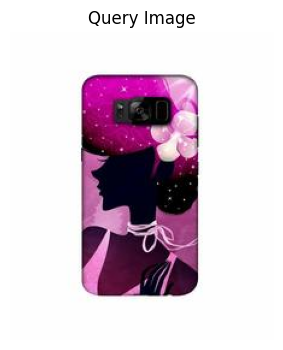

In [32]:
img = Image.open("/kaggle/input/product-images-dataset/small/01/01013f05.jpg").convert("RGB")

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis("off")
plt.title("Query Image")
plt.show()

# COMPUTE SIMILARITY

In [33]:
with torch.no_grad():
    query_embedding = model.encoder(query_image).cpu().numpy()


In [34]:
similarity = cosine_similarity(query_embedding, embeddings)

# TOP-N RECOMMENDATIONS

In [35]:
TOP_N = 5
top_indices = similarity[0].argsort()[-TOP_N:][::-1]


# SHOW RECOMMENDED IMAGES

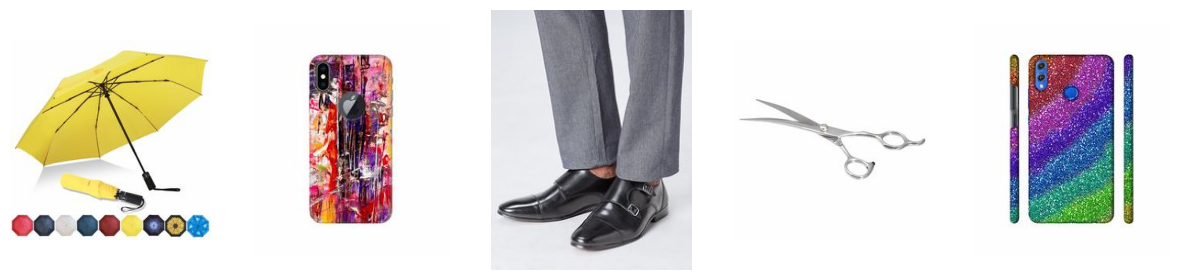

In [36]:
plt.figure(figsize=(15,5))

for i, idx in enumerate(top_indices):
    img_path = os.path.join(IMAGE_DIR, image_names[idx])
    img = Image.open(img_path)

    plt.subplot(1, TOP_N, i+1)
    plt.imshow(img)
    plt.axis("off")

plt.show()


# New Code Here